In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
#from colossus.cosmology import cosmology as cc

import matplotlib.pyplot as plt

# Test of pipeline

### Step 1: Setup `Survey` parameters

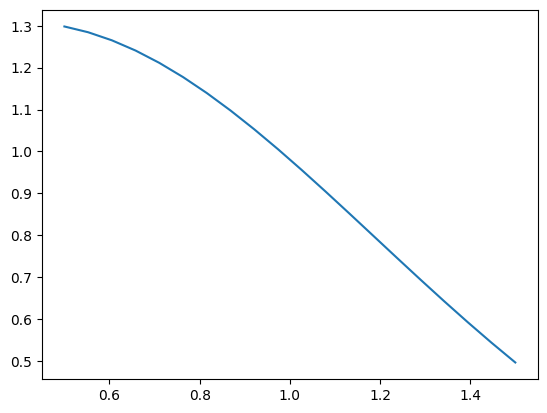

In [3]:
zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

plt.plot(zs, pz)

In [4]:
# Setup Survey

from galCIB import Survey 

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)
elg_survey = Survey(zs,pz,2.225,
                    ells, 1024,
                    name='elg')

In [5]:
# Setup Cosmology

ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

from galCIB import Cosmology

cosmo = Cosmology(elg_survey.z, ks, Mh)

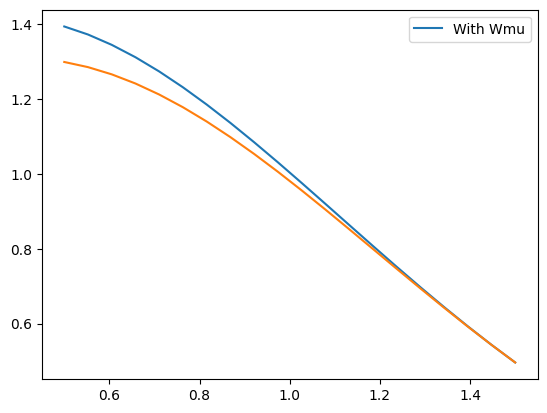

In [6]:
# Calculate window 

elg_survey.compute_windows(cosmo,True)
plt.plot(cosmo.z, elg_survey.Wg, label = 'With Wmu')
plt.plot(zs, pz)
plt.legend(loc='best')

In [7]:
# Setup galaxy HOD

from galCIB import get_hod_model
elg_hod_model = get_hod_model("DESI-ELG", cosmo)

In [8]:
# Setup Satellite Profile Model 

from galCIB import SatProfile

theta_sat = np.array([0.58, 6.14, 0.67])
elg_sat_profile = SatProfile(cosmo, theta_sat,
                             profile_type='mixed')

/Users/tkarim/research/galCIB/src/galCIB/satprofile/profile.py:37: UserWarning: For the default mixed profile, theta should be [f_exp, tau_exp, lambda_NFW].
  warnings.warn(


## Test `cib` module

In [29]:
theta_eta = np.array([1, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.78,0.40, #mu0_peak, mup_peak
                      2.47,0.45,1.93]) #sigmaM0, tau, zc
theta_snu = np.array([2.7, 1.98, 21.13, 0.21, 1.7]) #L0, beta_dust, T0, alpha_dust, gamma_dust

from galCIB import CIBModel
cib_model = CIBModel(hod=elg_hod_model,
               cosmo=cosmo)

# Setup default SFR

from galCIB import get_sfr_model
sfr_m21_factory = get_sfr_model("M21")

sfr_m21=sfr_m21_factory(cib_model.BAR_grid,
                        cib_model.z_ratio)
sfr_m21(cosmo.Mh_grid[0], cosmo.z, theta_eta).shape

(100, 20)

In [30]:
# Setup default parametric SED

from galCIB import get_snu_model
snu_m21_factory = get_snu_model("Y23")
snu_m21=snu_m21_factory(cib_model.nu_prime,cosmo.z)

Text(0, 0.5, 'Dust Temperature')

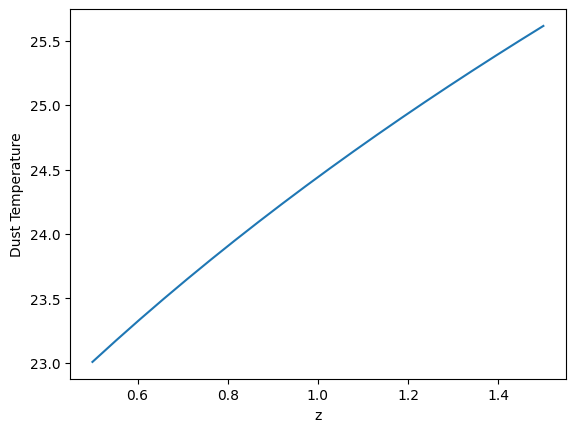

In [31]:
from galCIB.cib.default_snu import _compute_Tdust, _compute_nu0_z, _compute_prenu0, _compute_postnu0
tst_Tdust = _compute_Tdust(21.13, 0.21, cosmo.z)

plt.plot(cosmo.z,tst_Tdust)
plt.xlabel("z")
plt.ylabel("Dust Temperature")

Why $\gamma$ in dust should be sampled as a parameter.

In [32]:
zcib = np.arange(0,10, 0.1)
tst_Tdust_cib = _compute_Tdust(21.13, 0.29, zcib)
tst_nu0z_cib = _compute_nu0_z(1.98, tst_Tdust_cib, 1.7)

Text(0, 0.5, "$\\nu_{0} = \\nu_{0}'/(1+z)$ GHz")

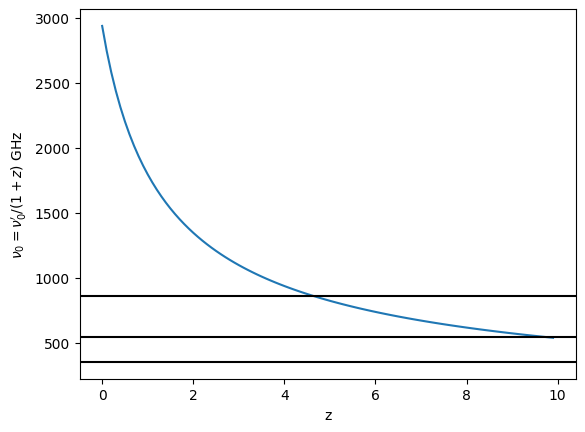

In [33]:
plt.plot(zcib, (tst_nu0z_cib/1e9)/(1+zcib))
plt.axhline(857, c = 'k')
plt.axhline(545, c = 'k')
plt.axhline(353, c = 'k')
plt.xlabel("z")
plt.ylabel(r"$\nu_{0} = \nu_{0}'/(1+z)$ GHz" )

Clearly, affects the two channels of Planck.

In [34]:
Td_K25 = _compute_Tdust(21.13, 0.21, cosmo.z)
nu0z_K25 = _compute_nu0_z(1.98, Td_K25, 1.7)

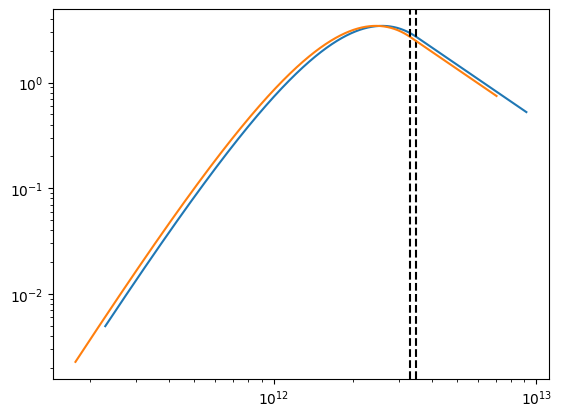

In [36]:
zidx=15
plt.loglog(cib_model.nu_prime[:,zidx],
         snu_m21(theta_snu)[:,zidx])

plt.axvline(nu0z_K25[zidx], c = 'k', ls = '--')

zidx=5
plt.loglog(cib_model.nu_prime[:,zidx],
         snu_m21(theta_snu)[:,zidx])
plt.axvline(nu0z_K25[zidx], c = 'k', ls = '--')

In [37]:
import scipy.constants as con
h_p = con.h  # Plank's constant 6.62607004e-34 SI units
c_light = 299792458e-3  # Km/sec
k_B = con.k  # Boltzmann constant 1.38064852e-23 SI

In [38]:
def Theta(nu, z):
    # calculating only for nu < nu0
    # normalised SED such that theta(nu0) = 1
    num = mod_blackbody(z, nu)
    # nu0 = 2000*1.e9  # Hz => approximately taken from Fig.1 of 2010.16405
    nu0z = nu0_z(z)
    denom = mod_blackbody(z, nu0z)
    return num/denom

from scipy.special import lambertw
def nu0_z(z):
    """
    for mod blackboy approximation, for the SED we have
    dlntheta/dlnnu = -gamma for nu=nu0.
    Here theta is the modified blackbody spectrum. In order to find nu0
    which isredshift dependent, we need to take a derivative and solve
    for this numerically. In the end it comes out in the form
    (x-(3+beta+gamma))e(x-(3+beta+gamma)) = -(3+beta+gamma)e(-(3+beta+gamma))
    The solution is x-(3+beta+gamma) = W(-(3+beta+gamma)e(-(3+beta+gamma)))
    here W is Lambert's W fnction which is implemented in scipy.
    x = hnu/KT
    """
    beta = 1.98
    gamma = 1.7
    y = -(3+beta+gamma)*np.exp(-(3+beta+gamma))
    xx = lambertw(y)
    x = xx + (3+beta+gamma)
    Td = Tdust(z)
    nu0z = np.real(x*k_B*Td/h_p)
    return nu0z

def mod_blackbody(z, nu):
    beta = 1.98
    Bnu = B_nu(z, nu)
    result = Bnu
    result *= nu**beta
    
    return result

def B_nu(z, nu):
    # nu in Hz and not GHz
    Td = Tdust(z)
    res = 2.*h_p*nu**3/(c_light*1.e3)**2
  
    x = h_p*nu/k_B/Td
    
    res /= (np.exp(x) - 1)
    return res

def Tdust(z):
    T0 = 21.13  # Planck CIB 2013 paper
    alpha = 0.21
    result = T0*(1.+z)**alpha
    return result

In [39]:
Theta_M21 = Theta(cib_model.nu_prime[:,zidx],cosmo.z[zidx])

In [42]:
nu0z_M21 = nu0_z(cosmo.z)

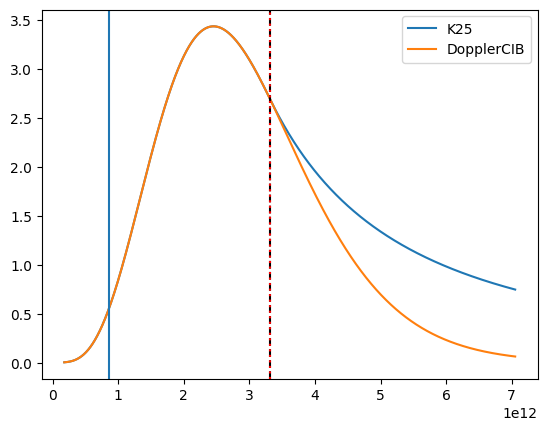

In [45]:
plt.plot(cib_model.nu_prime[:,zidx],
         snu_m21(theta_snu)[:,zidx],
         label='K25')

plt.plot(cib_model.nu_prime[:,zidx],
         Theta_M21*2.7,label='DopplerCIB')

plt.axvline(nu0z_K25[zidx], c = 'k', ls = '--')
plt.axvline(nu0z_M21[zidx], c = 'r', ls = 'dotted')

plt.axvline(857*1e9)

plt.legend(loc='best')

In [32]:
cib_model = CIBModel(sfr_factory, None, elg_hod_model,
                     cosmo)

In [33]:
tst = sfr_factory(eta_fn, cib_model.BAR_grid,
            elg_hod_model.z_ratio)

In [44]:
cib_model.sfr(theta_eta)

TypeError: sfr_default() missing 2 required positional arguments: 'BAR_grid' and 'z_ratio'

In [40]:
tst(cosmo.Mh_grid[0],cosmo.z,
    theta_eta)

(100, 20)

In [80]:
# Setup Power Spectra

In [9]:
theta_cen = np.array([5.47, 11.64, 0.30, 0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.41, 10**11.20, 10**13.84, 1]) # As, M0, M1, alpha_sat
#theta_prof = np.array([0.58, 6.14, 0.67]) # fexp, tau, lambda_NFW
theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

In [10]:
from galCIB import PkBuilder

pow3d = PkBuilder(cosmo,elg_hod_model,elg_sat_profile,
                  theta_cen, theta_sat, theta_prof)

AttributeError: 'PkBuilder' object has no attribute '_cache_galaxy_integral'

In [11]:
plt.loglog(cosmo.k, pow3d.Pgg_2h[:,1])
plt.loglog(cosmo.k, pow3d.Pgg_1h[:,1])
plt.loglog(cosmo.k, pow3d.Pgg_2h[:,1] + pow3d.Pgg_1h[:,1])

NameError: name 'pow3d' is not defined

In [84]:
from galCIB import AnalysisModel

In [85]:
elg_cib = AnalysisModel(cosmo,elg_survey,
                        pow3d)

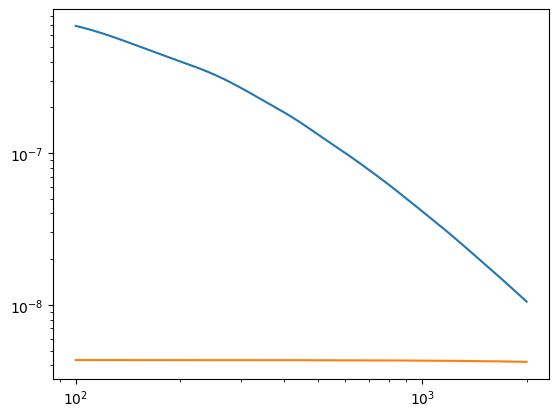

In [86]:
plt.loglog(elg_survey.ells, elg_cib.cl_gg_2h)
plt.loglog(elg_survey.ells, elg_cib.cl_gg_1h)

In [87]:
unwise_cib = AnalysisModel(cosmo,elg_survey,
                        pow3d_unwise)

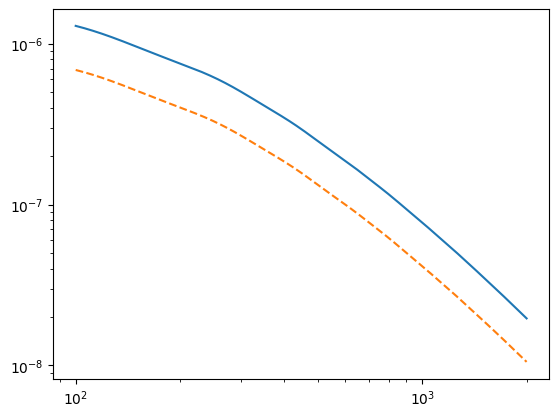

In [89]:
plt.loglog(elg_survey.ells, unwise_cib.cl_gg_2h)
#plt.loglog(elg_survey.ells, unwise_cib.cl_gg_1h)
plt.loglog(elg_survey.ells, elg_cib.cl_gg_2h,ls='--')

In [23]:
%%timeit 

zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)
elg_survey = Survey(zs,pz,2.225,
                    ells, 1024,
                    name='elg')

ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

cosmo = Cosmology(elg_survey.z, ks, Mh)

elg_survey.compute_windows(cosmo,True)

elg_hod_model = get_hod_model("DESI-ELG",elg_survey.z)

theta_sat = np.array([0.58, 6.14, 0.67])
elg_sat_profile = SatProfile(cosmo, theta_sat,
                             profile_type='mixed')

theta_cen = np.array([5.47, 11.64, 0.30, 0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.41, 10**11.20, 10**13.84, 1]) # As, M0, M1, alpha_sat
theta_prof = np.array([0.58, 6.14, 0.67]) # fexp, tau, lambda_NFW

pow3d = PkBuilder(cosmo,elg_hod_model,elg_sat_profile,
                  theta_cen, theta_sat, theta_prof)

elg_cib = AnalysisModel(cosmo,elg_survey,
                        pow3d)

/Users/tkarim/research/galCIB/src/galCIB/satprofile/profile.py:37: UserWarning: For the default mixed profile, theta should be [f_exp, tau_exp, lambda_NFW].
  warnings.warn(


274 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


About 7 hours for 100,000 calls

In [68]:
zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)
elg_survey = Survey(zs,pz,2.225,
                    ells, 1024,
                    name='elg')

ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

cosmo = Cosmology(elg_survey.z, ks, Mh)

elg_survey.compute_windows(cosmo,True)

elg_hod_model = get_hod_model("Zheng05",cosmo)

theta_sat = np.array([10**7, 11.52, -0.02, 1]) #M0, mu0_M1, mup_M1, alpha_sat
elg_sat_profile = SatProfile(cosmo, theta_sat,
                             profile_type='nfw')

theta_cen = np.array([11.26, 2.43, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM
theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

pow3d_unwise = PkBuilder(cosmo,elg_hod_model,elg_sat_profile,
                  theta_cen, theta_sat, theta_prof)

# elg_cib = AnalysisModel(cosmo,elg_survey,
#                         pow3d)

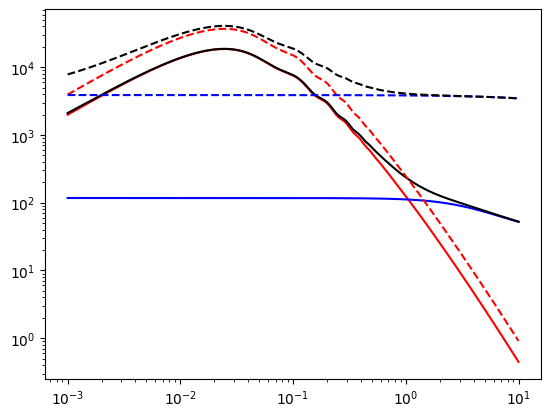

In [73]:
plt.loglog(cosmo.k, pow3d.Pgg_2h[:,1], ls = 'solid',c='r')
plt.loglog(cosmo.k, pow3d.Pgg_1h[:,1], ls = 'solid',c='b')
plt.loglog(cosmo.k, pow3d.Pgg_2h[:,1] + pow3d.Pgg_1h[:,1],
           ls = 'solid', c = 'k')


plt.loglog(cosmo.k, pow3d_unwise.Pgg_2h[:,1], ls ='dashed',c='r')
plt.loglog(cosmo.k, pow3d_unwise.Pgg_1h[:,1], ls ='dashed',c='b')
plt.loglog(cosmo.k, pow3d_unwise.Pgg_2h[:,1] + pow3d_unwise.Pgg_1h[:,1],
           ls ='dashed',c='k')

In [74]:
pow3d_unwise.Pgg_2h[:,1]/pow3d.Pgg_2h[:,1]

array([1.98689077, 1.98689065, 1.98689054, 1.98689042, 1.9868903 ,
       1.98689018, 1.98689006, 1.98688993, 1.98688981, 1.98688967,
       1.98688954, 1.98688941, 1.98688927, 1.98688913, 1.98688899,
       1.98688884, 1.98688869, 1.98688854, 1.98688839, 1.98688823,
       1.98688807, 1.98688791, 1.98688774, 1.98688757, 1.9868874 ,
       1.98688723, 1.98688705, 1.98688687, 1.98688668, 1.98688649,
       1.9868863 , 1.98688611, 1.98688591, 1.9868857 , 1.9868855 ,
       1.98688529, 1.98688507, 1.98688485, 1.98688463, 1.9868844 ,
       1.98688417, 1.98688394, 1.9868837 , 1.98688346, 1.98688321,
       1.98688295, 1.9868827 , 1.98688243, 1.98688217, 1.98688189,
       1.98688162, 1.98688133, 1.98688105, 1.98688075, 1.98688045,
       1.98688015, 1.98687984, 1.98687953, 1.9868792 , 1.98687888,
       1.98687854, 1.9868782 , 1.98687786, 1.98687751, 1.98687715,
       1.98687678, 1.98687641, 1.98687603, 1.98687564, 1.98687525,
       1.98687485, 1.98687444, 1.98687403, 1.9868736 , 1.98687

# Issues: 
- ~~Calculate $k$ for given $\ell$ per $z$, and re sample $P(k)$.~~ 
- ~~Integrate over the same $\ell$-to-$k$ grid~~
- ~~SFR Model test~~
- ~~SFR Model registry setup~~
- $S_{\nu}$ Model test
    - M21
    - ~~Y23~~
- $S_{\nu}$ Model registry setup 
    - M21
    - ~~Y23~~
- $S_{\nu}$ filter turn-on option and utils to convolve with Planck filter
- $\theta$ update method in `AnalysisModel`
- Write submodule on MCMC and setup `loglikelihood` method 
- Run MCMC with just $C_{\rm gg}$
- $P_{\rm CIB-CIB}$ and $P_{\rm g-CIB}$
- Refactor `pk.py`; compute.py to contain all the Pk functions? 
- Include color correction in `AnalysisModel`
- Include `Survey`-specific $\ell$ binning in `AnalysisModel`.